# Optimizer Example
Jena Climate RNN example showing comparsion between Adam and *newer* optimizers.
This is a regression model, using 3-hour data.

Richard Henry, 18-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.16.2'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

|Dataset|Architecture|Group|Type|
|---|---|---|---|
|Jena 3hr|RNN|Modern|Regression|

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [7]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [8]:
# Model / data parameters
blk_len=16*8      #Look back at two weeks of data
stp_len=8         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=64*8      #batch size of 2 months
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
for i in range(cut_len):
    for j in range(blk_len):
            xTrain[i][j][:]=xAll[i+j][:]

CPU times: total: 2.38 s
Wall time: 2.66 s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model functions
def model_core():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1,
                                  activation='linear')
        ]
    )
    return model
def model_build(myOpti):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model=model_core()
    model.compile(loss='mean_squared_error',
                  optimizer=myOpti,
                  metrics=['mean_absolute_error'])
    # Reduce variation in training...
    tf.random.set_seed(17)
    print("History Match:")
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    print("\n")
    print("Evaluate Model:")
    myEva=model.evaluate(xTrain,
                         y_train,
                         batch_size=bat_len)
    print("All Sample MSE:",myEva[0])
    print("All Sample MAE:",myEva[1])
    print("\n")
    print("Make Predictions:")
    myPre=model.predict(xTrain)
    print("\n")
    print("Timing:")
    return myHis,myPre

### First Model, Adam

In [12]:
%%time
h0,p0=model_build('adam')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 272ms/step - loss: 130.0092 - mean_absolute_error: 9.3698 - val_loss: 70.9607 - val_mean_absolute_error: 6.7760
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - loss: 51.6581 - mean_absolute_error: 5.7377 - val_loss: 51.1268 - val_mean_absolute_error: 5.6597
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - loss: 37.0710 - mean_absolute_error: 4.7959 - val_loss: 40.5871 - val_mean_absolute_error: 4.9813
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - loss: 28.9797 - mean_absolute_error: 4.2126 - val_loss: 33.2366 - val_mean_absolute_error: 4.4664
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - loss: 25.3057 - mean_absolute_error: 3.9312 - val_loss: 29.3219 - val_mean_absolute_error: 4.1882
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 271ms/step - loss: 23.3275 - mean_absolute_error: 3.7862 - val_loss: 26.6401 - val_mean_absolute_error: 4.0031
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - loss: 21.94

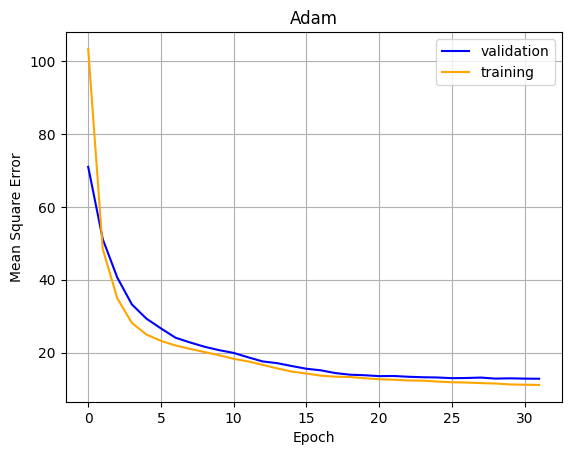

In [13]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h0.history['loss'], color='orange')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam')
plt.grid()
plt.show()

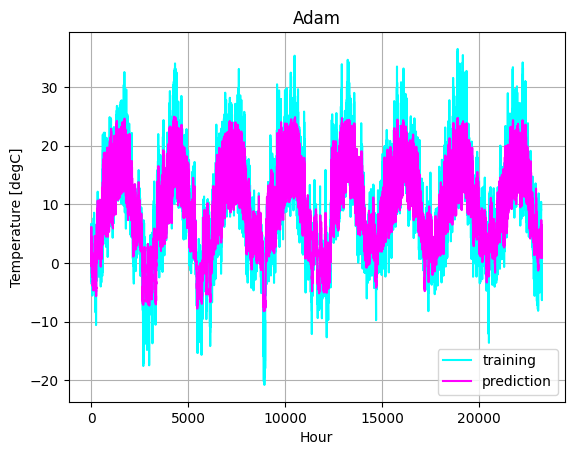

In [14]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam')
plt.grid()
plt.show()

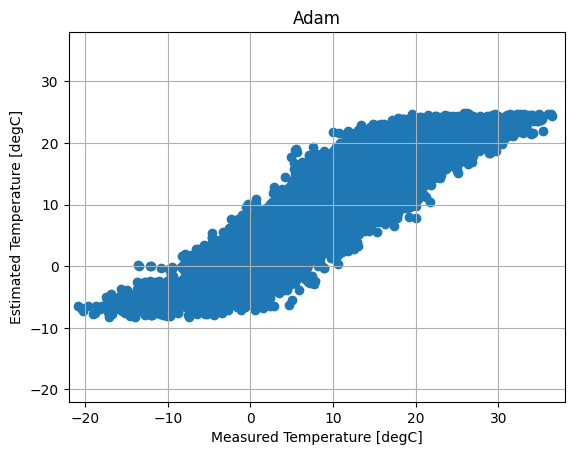

In [28]:
plt.scatter(y_train,p0.flatten())
plt.ylabel('Estimated Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam')
plt.grid()
plt.xlim([-22,38])
plt.ylim([-22,38])
plt.show()

### Second Model, Adam with Weight Decay

In [16]:
%%time
h1,p1=model_build('adamw')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 293ms/step - loss: 134.2478 - mean_absolute_error: 9.5261 - val_loss: 79.4666 - val_mean_absolute_error: 7.1621
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 333ms/step - loss: 52.0072 - mean_absolute_error: 5.6870 - val_loss: 42.0379 - val_mean_absolute_error: 4.9688
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - loss: 30.6019 - mean_absolute_error: 4.2720 - val_loss: 30.4391 - val_mean_absolute_error: 4.1699
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - loss: 24.5320 - mean_absolute_error: 3.8273 - val_loss: 25.6937 - val_mean_absolute_error: 3.8108
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - loss: 21.2663 - mean_absolute_error: 3.5815 - val_loss: 22.8746 - val_mean_absolute_error: 3.6060
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - loss: 19.2101 - mean_absolute_error: 3.3898 - val_loss: 20.0374 - val_mean_absolute_error: 3.3615
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - loss: 17.10

### Third Model, AdaFactor

In [17]:
%%time
h2,p2=model_build('adafactor')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - loss: 153.5708 - mean_absolute_error: 10.2788 - val_loss: 185.2018 - val_mean_absolute_error: 11.4013
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - loss: 147.5444 - mean_absolute_error: 10.0680 - val_loss: 177.5607 - val_mean_absolute_error: 11.1499
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - loss: 140.3000 - mean_absolute_error: 9.8053 - val_loss: 167.6631 - val_mean_absolute_error: 10.8128
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step - loss: 130.8139 - mean_absolute_error: 9.4522 - val_loss: 153.5962 - val_mean_absolute_error: 10.3083
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 300ms/step - loss: 117.7173 - mean_absolute_error: 8.9360 - val_loss: 134.8529 - val_mean_absolute_error: 9.5787
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step - loss: 100.9426 - mean_absolute_error: 8.2056 - val_loss: 113.5402 - val_mean_absolute_error: 8.6451
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/s

### 4th Model, LION

In [18]:
%%time
h3,p3=model_build('lion')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 301ms/step - loss: 133.4149 - mean_absolute_error: 9.5002 - val_loss: 84.2485 - val_mean_absolute_error: 7.4227
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 295ms/step - loss: 53.2384 - mean_absolute_error: 5.8240 - val_loss: 41.6698 - val_mean_absolute_error: 4.9844
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 309ms/step - loss: 30.8280 - mean_absolute_error: 4.3074 - val_loss: 30.6468 - val_mean_absolute_error: 4.2837
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 293ms/step - loss: 24.1858 - mean_absolute_error: 3.8512 - val_loss: 23.2543 - val_mean_absolute_error: 3.7454
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 293ms/step - loss: 21.4638 - mean_absolute_error: 3.6255 - val_loss: 20.6706 - val_mean_absolute_error: 3.5718
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - loss: 19.1184 - mean_absolute_error: 3.4330 - val_loss: 17.0363 - val_mean_absolute_error: 3.1952
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - loss: 16.93

### 5th Model, Adam with Nesterov Momentum

In [19]:
%%time
h4,p4=model_build('nadam')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 296ms/step - loss: 135.9675 - mean_absolute_error: 9.5718 - val_loss: 76.0728 - val_mean_absolute_error: 6.9477
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step - loss: 48.6462 - mean_absolute_error: 5.4304 - val_loss: 41.7239 - val_mean_absolute_error: 4.8981
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - loss: 30.4512 - mean_absolute_error: 4.2414 - val_loss: 32.3042 - val_mean_absolute_error: 4.2704
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 289ms/step - loss: 25.1380 - mean_absolute_error: 3.8557 - val_loss: 26.4980 - val_mean_absolute_error: 3.8735
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 295ms/step - loss: 21.9053 - mean_absolute_error: 3.6024 - val_loss: 23.7021 - val_mean_absolute_error: 3.6782
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 292ms/step - loss: 19.7066 - mean_absolute_error: 3.4215 - val_loss: 21.6054 - val_mean_absolute_error: 3.5334
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 299ms/step - loss: 17.88

### 6th Model, Follow the Regularized Leader

In [20]:
%%time
h5,p5=model_build('ftrl')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - loss: 153.4157 - mean_absolute_error: 10.2633 - val_loss: 190.1836 - val_mean_absolute_error: 11.5876
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - loss: 150.6954 - mean_absolute_error: 10.1756 - val_loss: 187.9768 - val_mean_absolute_error: 11.5374
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - loss: 148.0542 - mean_absolute_error: 10.0926 - val_loss: 185.0524 - val_mean_absolute_error: 11.4680
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 144.3513 - mean_absolute_error: 9.9752 - val_loss: 179.7002 - val_mean_absolute_error: 11.3317
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - loss: 136.9731 - mean_absolute_error: 9.7340 - val_loss: 162.3992 - val_mean_absolute_error: 10.8280
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - loss: 113.5547 - mean_absolute_error: 8.8418 - val_loss: 117.5380 - val_mean_absolute_error: 9.0460
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step

### 7th Model, AdaMax

In [21]:
%%time
h6,p6=model_build('adamax')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - loss: 139.8770 - mean_absolute_error: 9.7821 - val_loss: 106.1806 - val_mean_absolute_error: 8.5189
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - loss: 63.4004 - mean_absolute_error: 6.3161 - val_loss: 55.9523 - val_mean_absolute_error: 5.8680
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - loss: 37.9061 - mean_absolute_error: 4.7753 - val_loss: 40.8792 - val_mean_absolute_error: 4.9646
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - loss: 29.7106 - mean_absolute_error: 4.2105 - val_loss: 33.7222 - val_mean_absolute_error: 4.4264
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - loss: 25.8742 - mean_absolute_error: 3.9270 - val_loss: 29.8145 - val_mean_absolute_error: 4.1484
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - loss: 23.7120 - mean_absolute_error: 3.7747 - val_loss: 28.0199 - val_mean_absolute_error: 4.0112
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - loss: 22.1515 - 

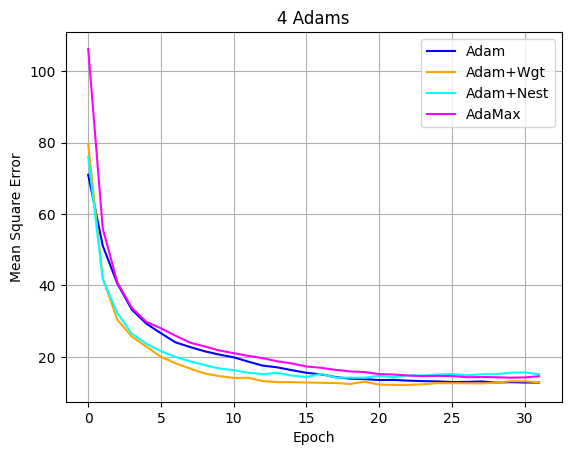

In [22]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange')
plt.plot(h4.history['val_loss'],color='cyan')
plt.plot(h6.history['val_loss'],color='magenta')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','AdaMax'])
plt.title('4 Adams')
plt.grid()
plt.show()

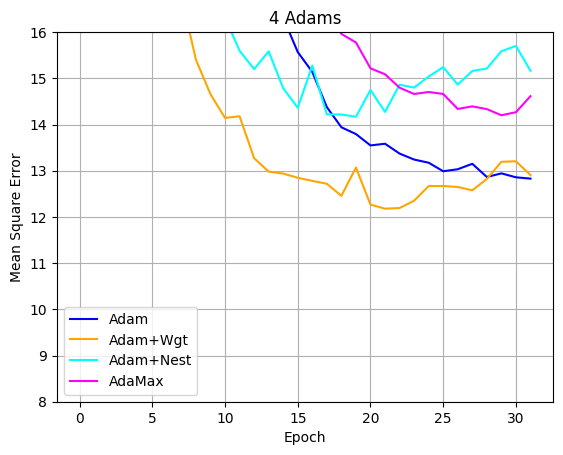

In [23]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange')
plt.plot(h4.history['val_loss'],color='cyan')
plt.plot(h6.history['val_loss'],color='magenta')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','AdaMax'])
plt.title('4 Adams')
plt.ylim([8,16])
plt.grid()
plt.show()

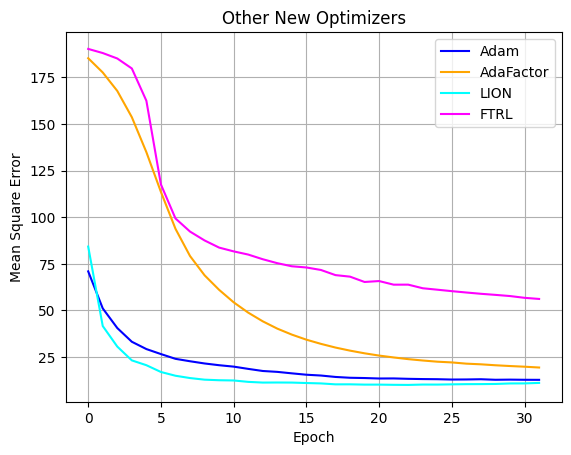

In [24]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h2.history['val_loss'],color='orange')
plt.plot(h3.history['val_loss'],color='cyan')
plt.plot(h5.history['val_loss'],color='magenta')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaFactor','LION','FTRL'])
plt.title('Other New Optimizers')
plt.grid()
plt.show()

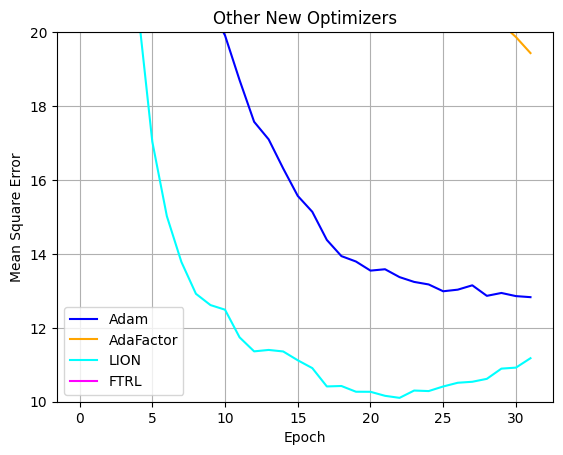

In [30]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h2.history['val_loss'],color='orange')
plt.plot(h3.history['val_loss'],color='cyan')
plt.plot(h5.history['val_loss'],color='magenta')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaFactor','LION','FTRL'])
plt.title('Other New Optimizers')
plt.ylim([10,20])
plt.grid()
plt.show()

## Model Summary

In [26]:
m=model_core()
m.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 128, 11)             │              23 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,544 (76.35 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 23 (96.00 B)